In [1]:
from openeye import oechem
import openeye
import oenotebook as oenb
import csv
import os
from pathlib import Path
import pandas as pd
import numpy as np

if not openeye.OEChemIsLicensed():
    raise RunTimeError("Can't find a valid OpenEye license")


In [2]:
def load_microstate_dictionary(sampl_id: str, microstate_folder: str= "./microstates/"):
    """Load a dictionary of microstates as defined by SAMPL from the microstate files.
    
    Parameters
    ----------
    sampl_id - the identifier for the molecule in sampl, e.g. SM12 
    
    Returns
    -------
    dict - key : microstate_id, value : oe_mol
    """

    microstates = dict()

    # Locate the file containing state definitions
    filename = "{}_microstates.csv".format(sampl_id)
    full_path = os.path.join(microstate_folder, filename)
    mypath = Path(full_path)
    if not mypath.is_file():
        raise ValueError("No microstate definitions were found for molecule {}. Check for typos.".format(sampl_id))
    
    # SAMPL6 CSV files are not OpenEye compatible, so instead we read the csv line by line and translate the smiles.
    with open(full_path, 'r') as csvfile:
        csvreader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
        
        for row in csvreader:
            key = row['microstate ID']
            val = oechem.OEGraphMol()
            oechem.OESmilesToMol(val, row['canonical isomeric SMILES'])
            microstates[key] = val
            
    return microstates


In [3]:
def load_result(sampl_id:str, pH_str: str, epik_output_folder:str="./output/states_per_pH/"):
    """Load a single result from Epik files using SAMPL ID, string of the pH with 1 decimal point.
    
    Returns
    -------
    list - OEMols with SD tags containing epik information, every OEMol represents one microstate
    """
    results = list()
        
    
    # Locate the file containing state definitions
    filename = "{}.epik.{}.sdf".format(sampl_id, pH_str)
    full_path = os.path.join(epik_output_folder, sampl_id, filename)
    mypath = Path(full_path)
    if not mypath.is_file():
        raise ValueError("No result file was found for molecule {} at pH {}. Check for typos.".format(sampl_id, pH_str))
    
    ifs = oechem.oemolistream()
#     ifs.SetFormat(oechem.OEFormat_SDF)
    if ifs.open(full_path):
    
        for mol in ifs.GetOEGraphMols():
            results.append(oechem.OEGraphMol(mol))

        ifs.close()
    else:
        raise IOError("Could not read input file.")
    return results


    

In [57]:
def map_result(microstates: dict, results: list):
    """Match states from results at one pH to microstates."""
    matches, unmatched = [], []
    for index, result_state in enumerate(results):
        mapping = {"Epik_Microstate": "{:d}".format(index),
                   "Epik_Molecule": result_state, "SMILES" : oechem.OECreateCanSmiString(result_state)}
        matched = False
        for microstate_id, microstate in microstates.items():
            newmatch = oechem.OEExactGraphMatch(result_state, microstate)
            if newmatch and matched:
#                 print(index, microstate_id, "matched more than once!")
                duplicate_mapping = dict(mapping)
                duplicate_mapping["SAMPL6_Microstate_ID"] = microstate_id
                duplicate_mapping["SAMPL6_Molecule"] = microstate                
                matches.append(duplicate_mapping)
            elif newmatch:
                matched = True
#                 print(index, microstate_id, "matched!")
                mapping["SAMPL6_Microstate_ID"] = microstate_id
                mapping["SAMPL6_Molecule"] = microstate
                matches.append(mapping)
                
        if matched == False:
#             print("Could not match: ", index)
            unmatched.append(mapping)
    return matches, unmatched

In [58]:
unmatched_states = pd.DataFrame(columns=["Epik_Microstate", "Epik_Molecule", "pH", "SAMPL6_ID", "SAMPL6_Microstate_ID", "SAMPL6_Molecule"])
matched_states = pd.DataFrame(columns=["Epik_Microstate", "Epik_Molecule", "pH", "SAMPL6_ID", "SAMPL6_Microstate_ID", "SAMPL6_Molecule"])

for molecule in range(24):
    SAMPL_ID = "SM{:02d}".format(molecule+1)
    microstates = load_microstate_dictionary(SAMPL_ID)
    for pH in np.linspace(2.0, 12.0, 101):
        pH_str = '{:.1f}'.format(pH)
        results = load_result(SAMPL_ID, pH_str)        
        matched, unmatched = map_result(microstates, results)
        for um in unmatched:
            um['pH'] = pH_str
            um['SAMPL6_ID'] = SAMPL_ID
            unmatched_states = unmatched_states.append(um, ignore_index=True)
        for m in matched:
            m['pH'] = pH_str
            m['SAMPL6_ID'] = SAMPL_ID
            matched_states = matched_states.append(m, ignore_index=True)  
        

In [65]:
unmatched_states_filtered = unmatched_states.drop(["pH", "SAMPL6_Microstate_ID", "SAMPL6_Molecule"], 1).drop_duplicates("SMILES")

# This is not working yet, perhaps a bug in map_result?
sampl_duplicated = matched_states.duplicated(["pH", "SMILES", "Epik_Microstate"])
epik_duplicated = matched_states.duplicated(["pH", "SMILES", "SAMPL6_Microstate_ID"])


,Epik_Microstate,Epik_Molecule,SAMPL6_ID,SMILES
0,3,,SM01,c1cc2c(cc1O)c3c(o2)C(=[OH+])[NH2+]CCC3
1,0,,SM02,c1ccc2c(c1)c(nc[nH+]2)Nc3cccc(c3)C(F)(F)F
69,0,,SM03,c1ccc(cc1)CC2=[NH2+2][NH+]=C(S2)NC(=O)c3cccs3
70,1,,SM03,c1ccc(cc1)CC2=[NH2+2]NC(=NC(=O)c3cccs3)S2
79,0,,SM04,c1ccc2c(c1)c(nc[nH+]2)NCc3ccc(cc3)Cl
162,2,,SM05,c1ccc(c(c1)[NH2+]C(=[OH+])c2ccc(o2)Cl)[NH+]3CCCCC3
163,1,,SM06,c1cc2ccc[nH+]c2c(c1)NC(=[OH+])c3cc(c[nH+]c3)Br
164,4,,SM06,c1cc2cccnc2c(c1)NC(=O)c3cc(c[nH+]c3)Br
218,0,,SM07,c1ccc(cc1)CNc2c3ccccc3[nH+]cn2
301,2,,SM08,Cc1ccc2c(c1)c(c(c(=[OH+])[nH]2)CC(=O)[O-])c3ccccc3

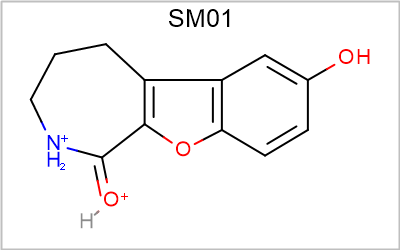
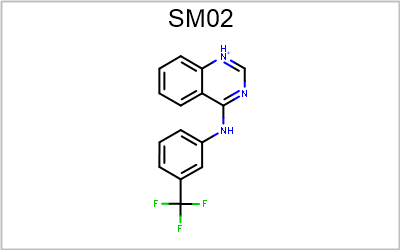
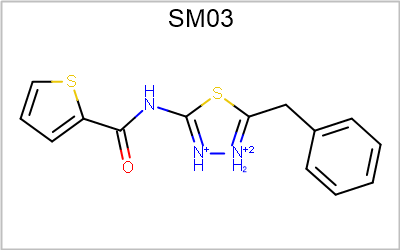
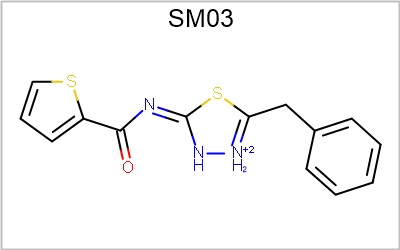
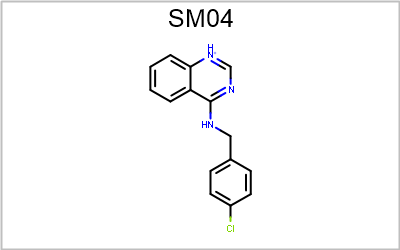
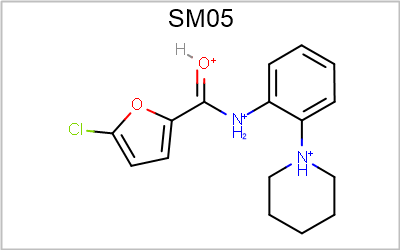
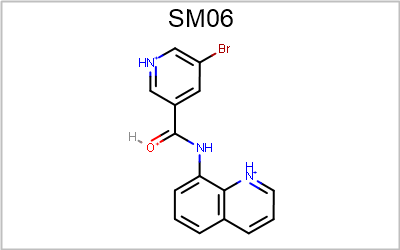
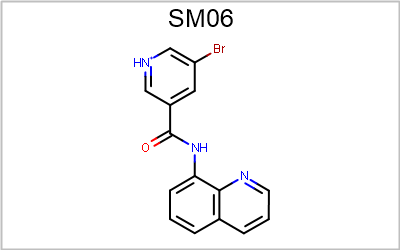
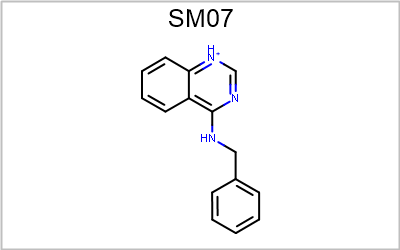
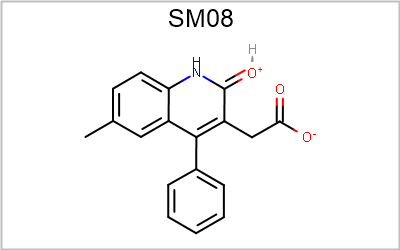
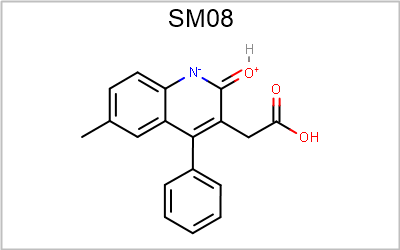
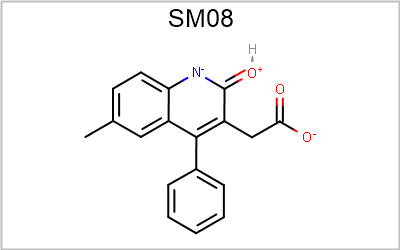
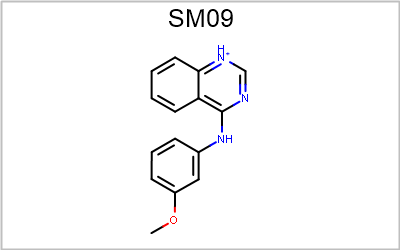
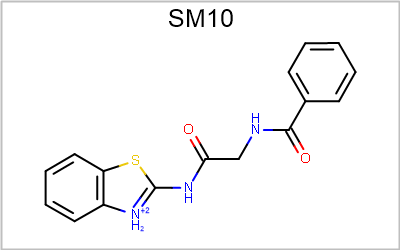
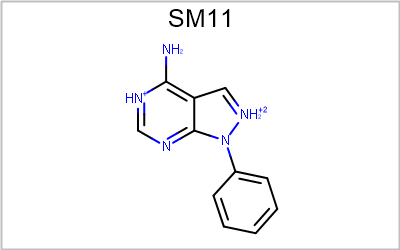
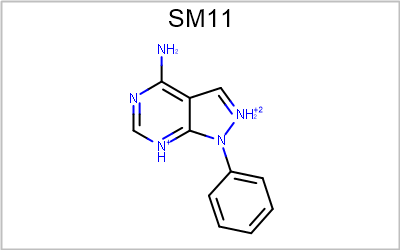
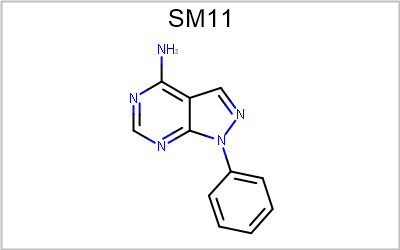
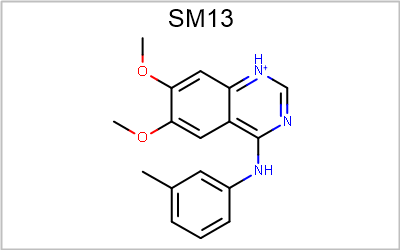
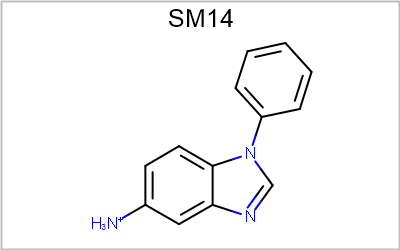
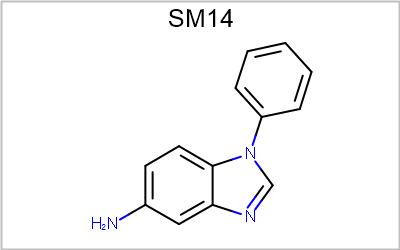
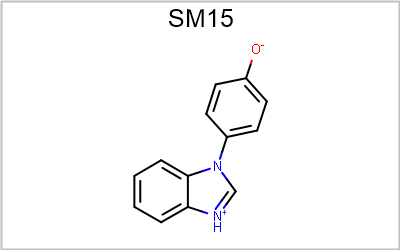
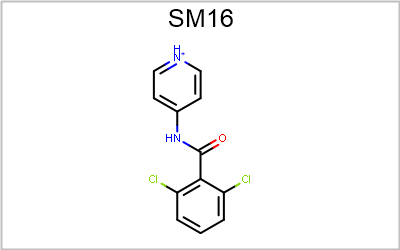
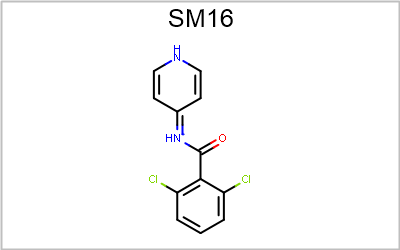
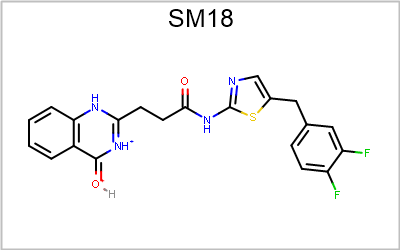
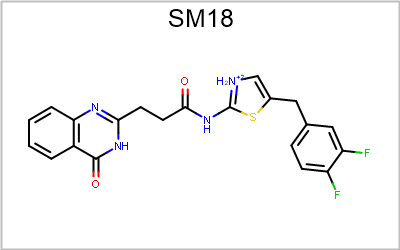
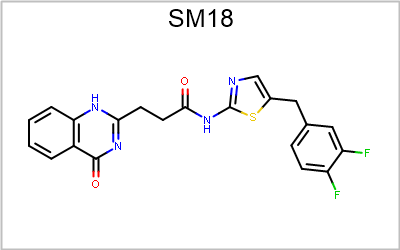
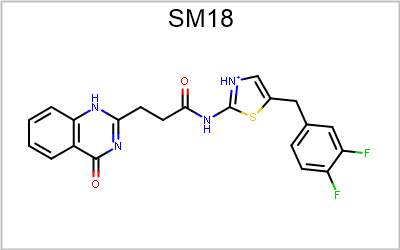
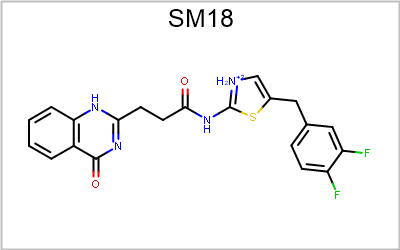
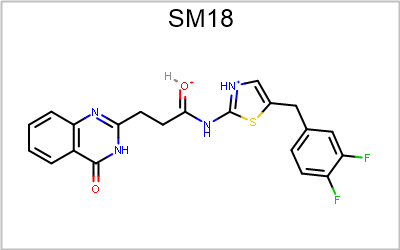
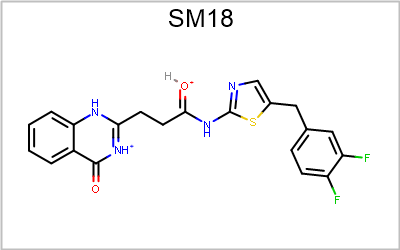
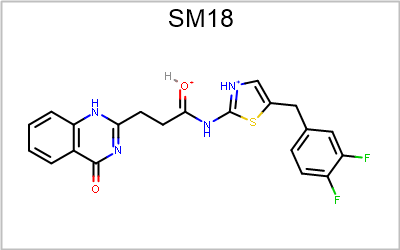
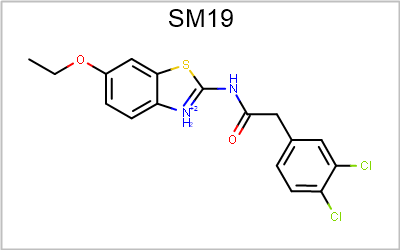
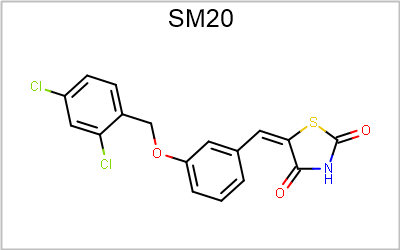
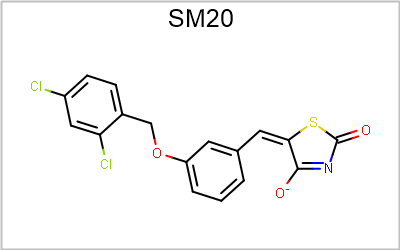
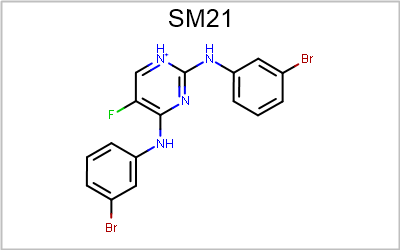
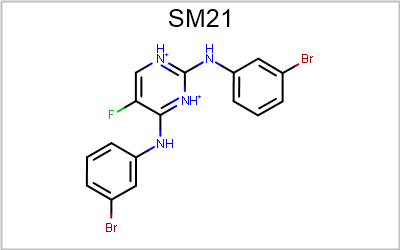
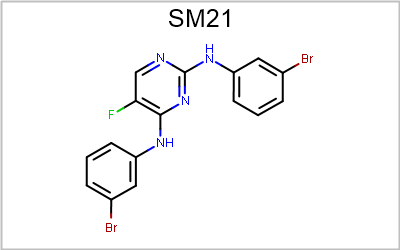
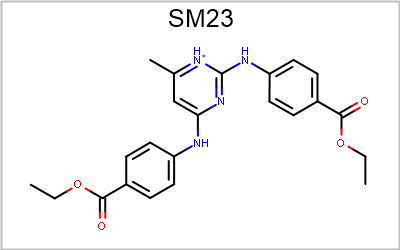
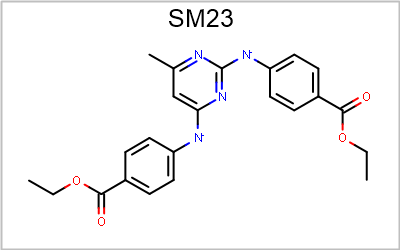
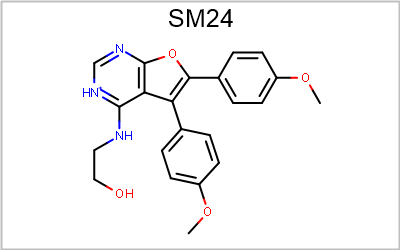
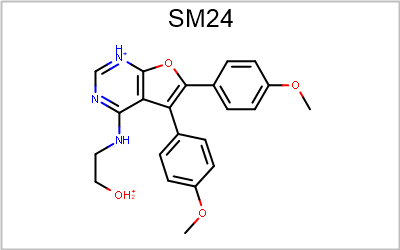
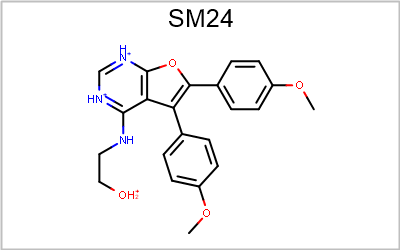
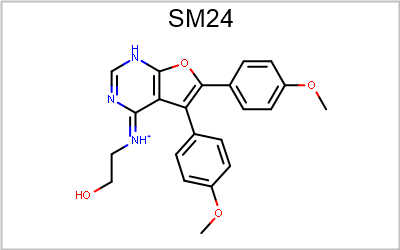

In [66]:
oenb.render_dataframe(unmatched_states_filtered, mol_col="Epik_Molecule")